<H1>Analisis Japanese GP 2024</H1>

In [1]:
#melakukan import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import fastf1
import fastf1.plotting
import math
from datetime import timedelta
import matplotlib as mpl

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap
from adjustText import adjust_text

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler,Normalizer

fastf1.plotting.setup_mpl()

In [2]:
#mendefinisikan fungsi

def getDuration(x): #mendapatkan durasi dari poin A ke B
    min=x.min()
    max=x.max()
    return max-min


def rotate_matrix (x, y, angle, x_shift=0, y_shift=0, units="DEGREES"): #melakukan proses rotasi matriks numpy
    """
    Rotates a point in the xy-plane counterclockwise through an angle about the origin
    https://en.wikipedia.org/wiki/Rotation_matrix
    :param x: x coordinate
    :param y: y coordinate
    :param x_shift: x-axis shift from origin (0, 0)
    :param y_shift: y-axis shift from origin (0, 0)
    :param angle: The rotation angle in degrees
    :param units: DEGREES (default) or RADIANS
    :return: Tuple of rotated x and y
    """

    # Shift to origin (0,0)
    x = x - x_shift
    y = y - y_shift

    # Convert degrees to radians
    if units == "DEGREES":
        angle = math.radians(angle)

    # Rotation matrix multiplication to get rotated x & y
    xr = (x * math.cos(angle)) - (y * math.sin(angle)) + x_shift
    yr = (x * math.sin(angle)) + (y * math.cos(angle)) + y_shift

    return xr, yr

def rotate(xy, *, angle): #melakukan proses rotasi matriks numpy
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

<H2> Analisis Kualifikasi </H2>

In [4]:
#memuat data dari fastf1

japgp_q_2024=fastf1.get_session(2024,'japan','q')#data kualifikasi
japgp_q_2024.load()

req         WARNING 	DEFAULT CACHE ENABLED! (189.38 MB) C:\Users\haryo\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.3.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '4', '55', '14', '81', '44', '16', '63', '22', '3', '27', '77', '23', '31', '18', '10', '20', '2', '24']


In [5]:
#mengambil lap tercepat masing - masing pembalap dan menambahkan informasi lainnya dalam dataframe
fastest_quali=pd.DataFrame()
for drv in japgp_q_2024.drivers:
    df_temp=pd.DataFrame(japgp_q_2024.laps.pick_driver(drv).pick_accurate().pick_wo_box().pick_fastest().get_telemetry())
    df_temp['drvName']=japgp_q_2024.get_driver(drv).Abbreviation
    df_temp['teamName']=japgp_q_2024.get_driver(drv).TeamName
    df_temp['teamColor']='#'+japgp_q_2024.get_driver(drv).TeamColor
    fastest_quali=pd.concat([fastest_quali,df_temp])

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

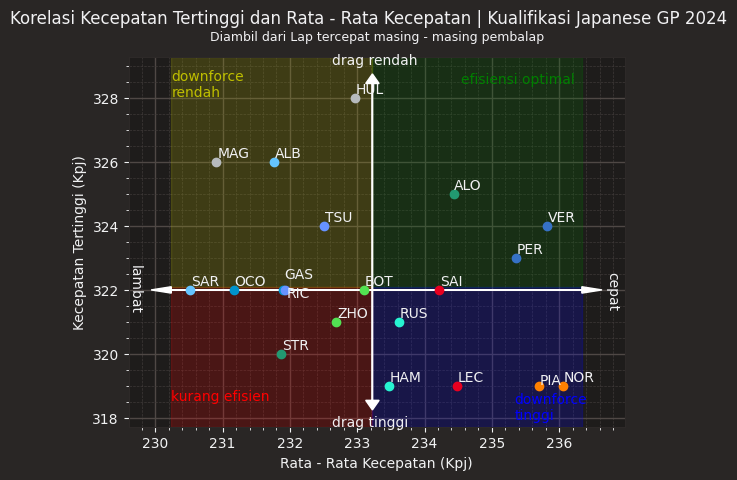

In [6]:
#visualisasi kuadran - kualifikasi
from adjustText import adjust_text
test=fastest_quali.groupby(['drvName','teamName','teamColor']).agg(maxSpeed=('Speed','max'),avgSpeed=('Speed','mean')).reset_index()
fig,ax=plt.subplots()

[ax.scatter(row['avgSpeed'],row['maxSpeed'],color=row['teamColor'],zorder=10) for i,row in test.iterrows()]
texts=[ax.annotate(row['drvName'],[row['avgSpeed'],row['maxSpeed']],zorder=10) for i,row in test.iterrows()]
#ax.axvline(test['avgSpeed'].mean(),color='lightgray')
#ax.axhline(test['maxSpeed'].mean(),color='lightgray')
xlims=ax.get_xlim()
ylims=ax.get_ylim()
maxSpeed_center=(test['maxSpeed'].mean()-min(ylims))/(max(ylims)-min(ylims))

ax.axvspan(xmin=test['avgSpeed'].mean(),xmax=max(xlims),ymin=maxSpeed_center,color='g',alpha=0.2)
ax.axvspan(xmax=test['avgSpeed'].mean(),xmin=min(xlims),ymax=maxSpeed_center,color='r',alpha=0.2)
ax.axvspan(xmax=test['avgSpeed'].mean(),xmin=min(xlims),ymin=maxSpeed_center,color='y',alpha=0.2)
ax.axvspan(xmin=test['avgSpeed'].mean(),xmax=max(xlims),ymax=maxSpeed_center,color='b',alpha=0.2)

ax.arrow(test['avgSpeed'].mean(),min(ylims),0,max(ylims)-min(ylims),color='white',head_width=0.2)
ax.arrow(test['avgSpeed'].mean(),max(ylims),0,-(max(ylims)-min(ylims)),color='white',head_width=0.2)
ax.arrow(min(xlims),test['maxSpeed'].mean()-0.3,max(xlims)-min(xlims),0,color='white',head_width=0.2)
ax.arrow(max(xlims),test['maxSpeed'].mean()-0.3,-(max(xlims)-min(xlims)),0,color='white',head_width=0.2)

ax.text(max(xlims)+0.4,test['maxSpeed'].mean()+0.3,'cepat',rotation=270,rotation_mode='anchor')
ax.text(min(xlims)-0.6,test['maxSpeed'].mean()+0.5,'lambat',rotation=270,rotation_mode='anchor')

ax.text(test['avgSpeed'].mean()-.6,max(ylims)+.6,'drag rendah')
ax.text(test['avgSpeed'].mean()-.6,min(ylims)-0.8,'drag tinggi')
props=dict(boxstyle='round',facecolor='w',alpha=0.5)
ax.text(min(xlims),min(ylims),'kurang efisien',color='r')
ax.text(max(xlims)-1,min(ylims)-0.6,'downforce\ntinggi',color='b')
ax.text(min(xlims),max(ylims)-0.4,'downforce\nrendah',color='y')
ax.text(max(xlims)-1.8,max(ylims),'efisiensi optimal',color='g')

ax.set_xlabel('Rata - Rata Kecepatan (Kpj)')
ax.set_ylabel('Kecepatan Tertinggi (Kpj)')
adjust_text(texts)
plt.suptitle('Korelasi Kecepatan Tertinggi dan Rata - Rata Kecepatan | Kualifikasi Japanese GP 2024')
plt.title('Diambil dari Lap tercepat masing - masing pembalap',fontsize=9)

plt.show()

In [8]:
avg_vs_min_Laptime=japgp_q_2024.laps.pick_accurate().pick_wo_box()[['LapTime','Driver','DriverNumber']].groupby(['Driver','DriverNumber']).agg(bestLap=('LapTime','min'),avgLap=('LapTime','mean')).reset_index()
avg_vs_min_Laptime['color']=avg_vs_min_Laptime['DriverNumber'].apply(lambda x: '#'+japgp_q_2024.get_driver(x).TeamColor)

scaler=StandardScaler()
avg_vs_min_Laptime['bestLapSecs']=avg_vs_min_Laptime['bestLap'].dt.total_seconds()
avg_vs_min_Laptime['avgLapSecs']=avg_vs_min_Laptime['avgLap'].dt.total_seconds()

train=avg_vs_min_Laptime[['bestLapSecs','avgLapSecs']]
transformed=scaler.fit_transform(train)
clustering = DBSCAN(eps=0.44, min_samples=4).fit_predict(transformed)
avg_vs_min_Laptime['clustering']=clustering
avg_vs_min_Laptime['clustering']=avg_vs_min_Laptime['clustering'].astype(str)
avg_vs_min_Laptime['Pengelompokan']=avg_vs_min_Laptime['clustering'].replace(['1','2','0','-1'],['leaders','backmarkers','midfield','siap siap wilhelmus'])

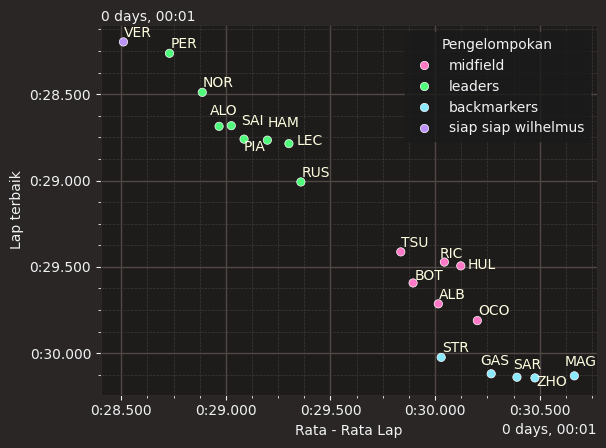

In [9]:
fig,ax=plt.subplots()
sns.scatterplot(data=avg_vs_min_Laptime,x='avgLap',y='bestLap',hue='Pengelompokan',zorder=10,ax=ax)
texts=[ax.annotate(row['Driver'],[row['avgLap'],row['bestLap']],zorder=10,color='lightyellow') for i,row in avg_vs_min_Laptime.iterrows()]

ylims=ax.get_ylim()
xlims=ax.get_xlim()
centre=(max(xlims)/2,max(ylims)/2)

ax.set_xlabel('Rata - Rata Lap')
ax.set_ylabel('Lap terbaik')
props=dict(boxstyle='round',facecolor='w',alpha=0.5)

adjust_text(texts)
colors = fastest_quali[['teamName','teamColor']].drop_duplicates().set_index('teamName').to_dict()['teamColor']
labels = list(colors.keys())[::-1]
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

In [14]:
fastest_quali.loc[:,'miniSect']=np.round(fastest_quali['RelativeDistance'].to_numpy()/(1/25))

speed_segments=fastest_quali[['Speed','miniSect','drvName','teamColor']]

dfSpeed=speed_segments.sort_values('Speed').drop_duplicates(subset='miniSect', keep='last').sort_values('miniSect').reset_index(drop=True)
listProp=dfSpeed[['drvName','teamColor']].value_counts(['drvName','teamColor'],normalize=True).reset_index()

single_lap = pd.DataFrame(japgp_q_2024.laps.pick_driver('PER').pick_fastest().get_telemetry())[['X','Y','RelativeDistance']]
single_lap['miniSect']=single_lap['RelativeDistance'].apply(lambda x: int(x/(1/25)))
single_lap=single_lap.merge(dfSpeed,on='miniSect')
single_lap=single_lap.merge(single_lap[['drvName']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'id'}),on='drvName')#id dari 0
single_lap['teamColor']=single_lap['drvName'].apply(lambda x:'#'+japgp_q_2024.get_driver(x).TeamColor)
single_lap=single_lap.merge(single_lap[['teamColor']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'idTeam'}),on='teamColor')#id dari 0
circuit_info = japgp_q_2024.get_circuit_info()

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


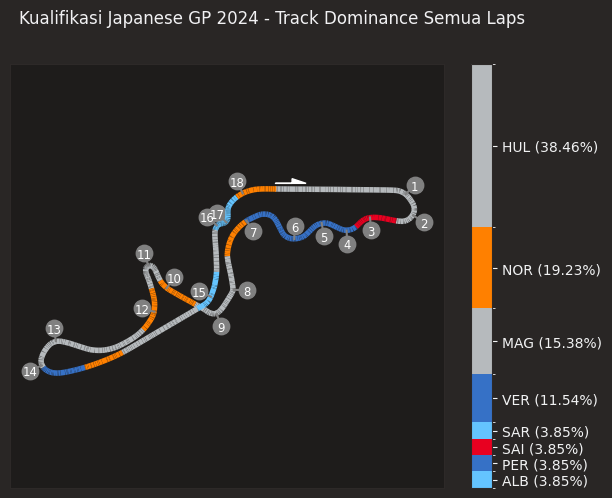

In [17]:
circRot=circuit_info.rotation
x,y=rotate_matrix(single_lap['X'].values,single_lap['Y'].values,circRot)


listProp.sort_values('proportion',inplace=True)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_avg=single_lap['idTeam'].to_numpy().astype(float)

#teamColor=single_lap[['id','tc']].drop_duplicates()
cmap = ListedColormap(single_lap['teamColor'].drop_duplicates().to_list())
lc_comp = LineCollection(segments, norm=plt.Normalize(0, cmap.N), cmap=cmap)
lc_comp.set_array(fastest_avg)
lc_comp.set_linewidth(4)


fig,ax=plt.subplots(figsize=(7,5.5))
    

fig.suptitle(
        f"Kualifikasi Japanese GP 2024 - Track Dominance Semua Laps"
    )
        
ax.add_collection(lc_comp)
ax.axis('equal')
ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

offset_vector = [700, 0] 
# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=math.radians(circRot))

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=math.radians(circRot))

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')
    

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')
plt.arrow(x[0],y[0]+300,+900,0,color='white',shape='right',head_width=500)
bounds=[i*10 for i in(listProp.sort_values('proportion')['proportion'].to_list())]
bounds.insert(0,0)
boundsx=[]
mem=0
for i in bounds:
    i+=mem
    mem=i
    boundsx.append(i)


cmap = ListedColormap(listProp['teamColor'].to_list())
norm = BoundaryNorm(boundsx, cmap.N)

cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),ax=ax,spacing='proportional')
initial=0
ticksList=[]
for i in listProp['proportion']:
    if i!=0:
        ticksList.append((((i*10)/2)+initial))
        initial+=i*10

cbar.set_ticks(ticksList)
#listProp['bounds']=boundsx
labels=[]
for j,k in listProp.iterrows():
    label=f'{k["drvName"]} ({round(k["proportion"]*100,2)}%)'
    labels.append(label)

cbar.set_ticklabels(labels)#ambil driver name dari variabel!!!
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
drvLaps=japgp_q_2024.laps[['DriverNumber','LapNumber']].groupby('DriverNumber').max()
all_quali=pd.DataFrame()
for drv in japgp_q_2024.drivers:
    laps=japgp_q_2024.laps.pick_driver(drv)
    
    for i in range(1,int(drvLaps[drvLaps.index==drv]['LapNumber'].iloc[0])):
        try:
            df_temp=pd.DataFrame(laps.pick_lap(i).pick_accurate().pick_wo_box().get_telemetry())
            df_temp['drvName']=japgp_q_2024.get_driver(drv).Abbreviation
            df_temp['teamName']=japgp_q_2024.get_driver(drv).TeamName
            df_temp['teamColor']='#'+japgp_q_2024.get_driver(drv).TeamColor
            df_temp['LapNumber']=i
            all_quali=pd.concat([all_quali,df_temp])
        except:
            continue
all_quali['miniSect']=(np.round(all_quali['RelativeDistance'].to_numpy()/(1/2))+1).astype(int)

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

In [16]:
first_set=all_quali[['drvName','Time','miniSect','LapNumber','teamColor','teamName']].groupby(['drvName','miniSect','LapNumber','teamColor','teamName']).agg(getDuration).reset_index()
theoretical_best_minisectors=first_set[['drvName','Time','miniSect','teamColor','teamName']].groupby(['drvName','miniSect','teamColor','teamName']).min().reset_index()
sum_tbest_minisectors=theoretical_best_minisectors.groupby(['drvName','teamColor','teamName']).agg(IdealmSTime=('Time','sum')).reset_index()


allLaps=pd.DataFrame(japgp_q_2024.laps.pick_accurate().pick_wo_box()[['Driver','DriverNumber','LapTime','Sector1Time','Sector2Time','Sector3Time','Compound','Team']])

fast_agg=allLaps[['Driver','DriverNumber','LapTime','Sector1Time','Sector2Time','Sector3Time','Team']].groupby(['Driver','DriverNumber','Team']).agg(BestLap=('LapTime','min'),BestS1=('Sector1Time','min'),BestS2=('Sector2Time','min'),BestS3=('Sector3Time','min'))

fast_agg['TheoreticalBest']=fast_agg['BestS1']+fast_agg['BestS2']+fast_agg['BestS3']
fast_agg.reset_index(inplace=True)
fast_agg=fast_agg.merge(sum_tbest_minisectors, left_on='Driver', right_on='drvName')
fast_agg.sort_values(by='BestLap',inplace=True)

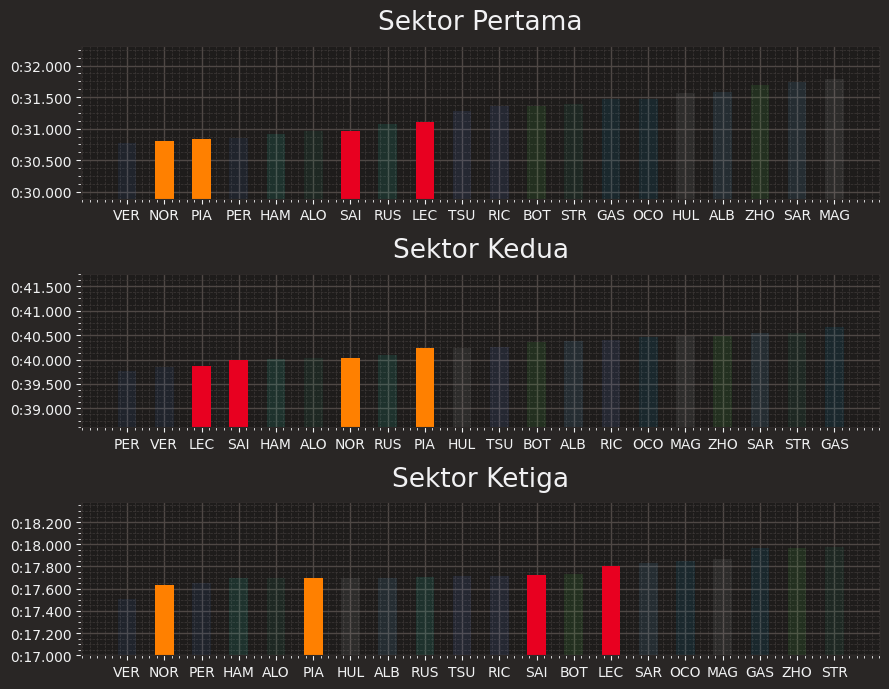

In [17]:
fig,ax=plt.subplots(3,1,figsize=(9,7))
fast_agg.sort_values('BestS1',inplace=True)
for i,row in fast_agg.iterrows():
    if row['Team'] in ['Ferrari','McLaren']:
        alphaVar=1
    else:
        alphaVar=0.1
    #bottom=np.zeros(len(fast_agg)).astype('<m8[ns]')
    ax[0].bar(x=row['Driver'],height=row['BestS1'],width=0.5,color=row['teamColor'],alpha=alphaVar)
    #bottom+=row['BestS1'].to_numpy()
    y1,y2=ax[0].get_ylim()
    y1=y2*0.925
    #y2=y2*0.955
    ax[0].set_ylim(y1,y2)
fast_agg.sort_values('BestS2',inplace=True)
for i,row in fast_agg.iterrows():
    if row['Team'] in ['Ferrari','McLaren']:
        alphaVar=1
    else:
        alphaVar=0.1
    ax[1].bar(x=row['Driver'],height=row['BestS2'],width=0.5,color=row['teamColor'],alpha=alphaVar)
    #bottom+=row['BestS2'].to_numpy()
    y1,y2=ax[1].get_ylim()
    y1=y2*0.925
    #y2=y2*0.955
    ax[1].set_ylim(y1,y2)
fast_agg.sort_values('BestS3',inplace=True)
for i,row in fast_agg.iterrows():
    if row['Team'] in ['Ferrari','McLaren']:
        alphaVar=1
    else:
        alphaVar=0.1
    ax[2].bar(x=row['Driver'],height=row['BestS3'],width=0.5,color=row['teamColor'],alpha=alphaVar)
    y1,y2=ax[2].get_ylim()
    y1=y2*0.925
    #y2=y2*0.955
    ax[2].set_ylim(y1,y2)
ax[0].set_title('Sektor Pertama')
ax[1].set_title('Sektor Kedua')
ax[2].set_title('Sektor Ketiga')
colors = fast_agg[['teamName','teamColor']].drop_duplicates().set_index('teamName').to_dict()['teamColor']
labels = list(colors.keys())[::-1]
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
#fig.legend(handles, labels)
fig.tight_layout()
plt.show()